In [38]:
import sys
!{sys.executable} -m pip install numpy matplotlib qiskit qiskit-aer qiskit-ibm-runtime pylatexenc
import numpy as np
from qiskit import *
from qiskit_aer import *
from qiskit.visualization import plot_histogram


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Vamos a crear un circuito cuántico con un solo qbit "q" del cual mediremos el valor antes y después de aplicarle una puerta lógica Hadamard que debería de pasar su valor de `|0>` a `1/2*|0> + 1/2*|1>`

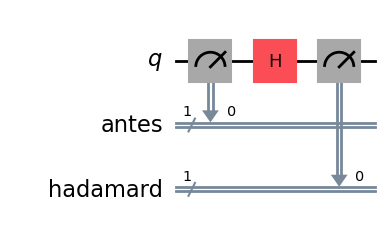

In [39]:
q = QuantumRegister(1, "q")

c1 = ClassicalRegister(1, "antes")
c2 = ClassicalRegister(1, "hadamard")

circuit = QuantumCircuit(q, c1, c2)

circuit.measure(0, 0)

circuit.h(0)

circuit.measure(0, 1)

circuit.draw(output='mpl')

In [40]:
backend = Aer.get_backend("qasm_simulator")
result = backend.run(circuit, backend=backend, shots=10000).result()

A continuación pintamos el resultado antes y después de haber puesto nuestro qbit en el estado `1/2*|0> + 1/2*|1>` después de ejecutar el programa 10.000 veces, deberíamos de ver el 50% de los resultados en 00 y el 50% de los resultados en 01, donde el primer dígito es el bit clásico "antes" y el segundo dígito es el bit clásico "después".

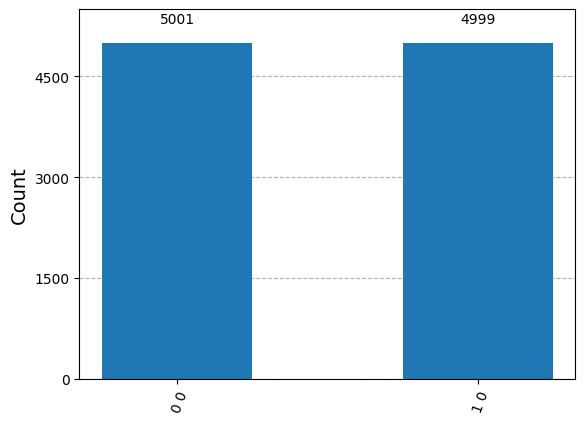

In [41]:
plot_histogram(result.get_counts(circuit))

A continuación vamos a preparar el circuito cuántico para realizar una teleportación cuántica, donde Alice va a mandar un mensaje a Bob mediante el entrelazamiento cuántico.

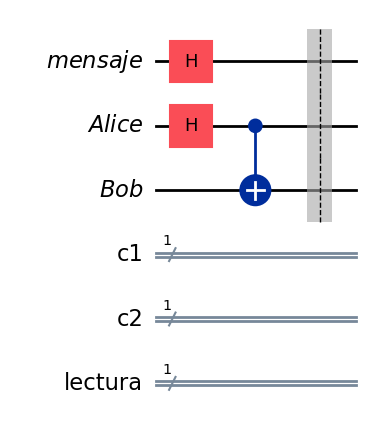

In [49]:
mensaje = QuantumRegister(1, "mensaje")
alice = QuantumRegister(1, "Alice")
bob = QuantumRegister(1, "Bob")

c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")

lectura = ClassicalRegister(1, "lectura")

telecircuit = QuantumCircuit(mensaje, alice, bob, c1, c2, lectura)

telecircuit.h(0)

telecircuit.h(1)
telecircuit.cx(1, 2)

telecircuit.barrier()

telecircuit.draw(output='mpl')

Aquí Alicia ha preparado el contenido del mensaje y ha creado un canal de comunicación con Bob.

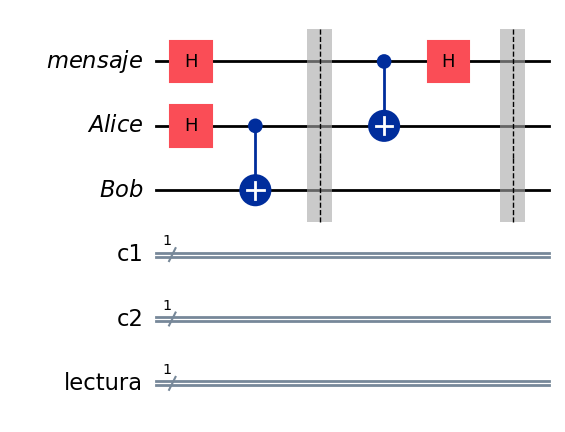

In [50]:
telecircuit.cx(0, 1)
telecircuit.h(0)

telecircuit.barrier()

telecircuit.draw(output='mpl')

A continuación Alicia ha preparado el mensaje para mandarlo a Bob con su contenido original `1/2*|0> + 1/2|1>`

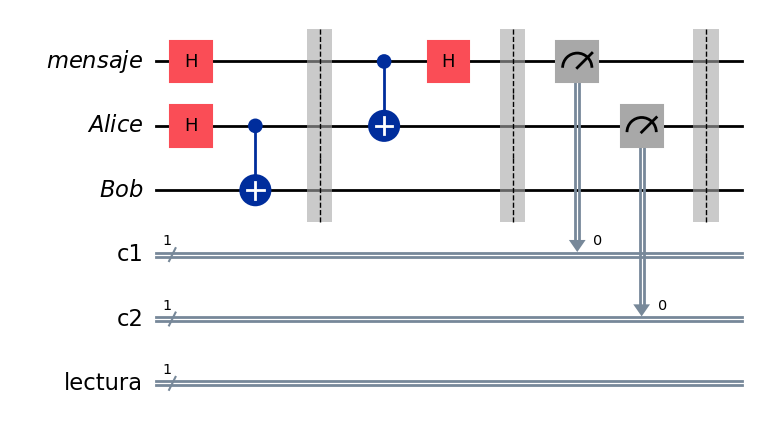

In [51]:
telecircuit.measure(0, 0)
telecircuit.measure(1, 1)

telecircuit.barrier()

telecircuit.draw(output='mpl')

Alicia observa el mensaje y su própio canal de comunicación y guarda los resultados de la medida en c1 y c2, lo que equivale a darle al botón de mandar el mensaje.

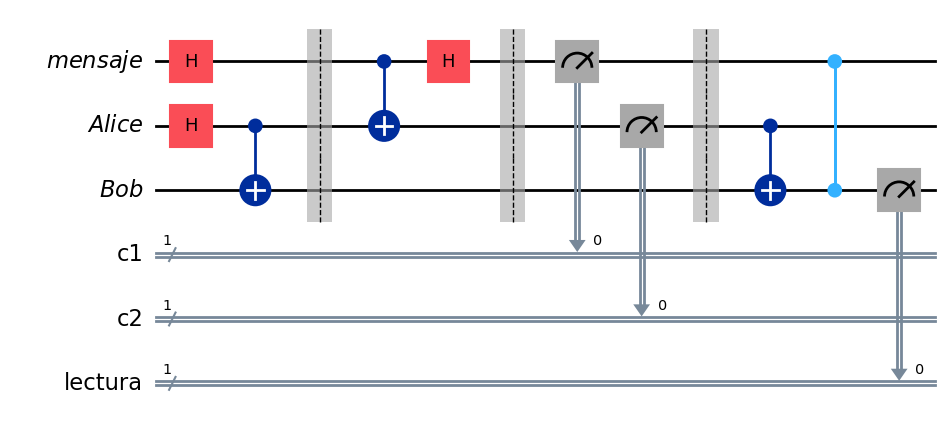

In [52]:
telecircuit.cx(1, 2)
telecircuit.cz(0, 2)

telecircuit.measure(2, 2)

telecircuit.draw(output='mpl')

En ese momento Bob puede leer c1 y c2 (en el diagrama está representado como que lee mensaje y Alice, pero en la vida real leería de los bits clásicos c1 y c2 donde solo él tiene acceso), y según si hay un 0 o un 1, aplica los operadores X y Z a su propio canal antes de leer.

Después de leer en su canal, dispone del mensaje original mandado por Alice en el bit "lectura".

In [54]:
result = backend.run(telecircuit, backend=backend, shots=10000).result()

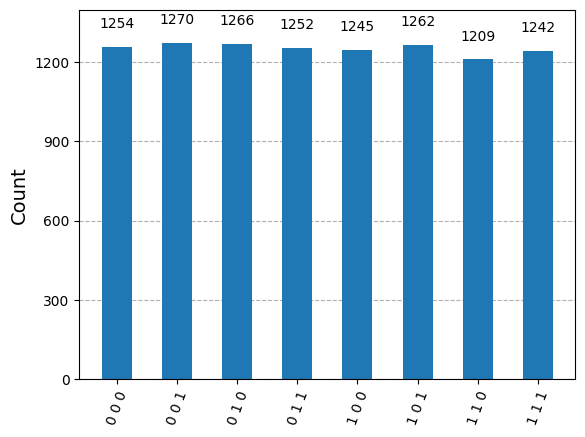

In [55]:
plot_histogram(result.get_counts(telecircuit))

Podemos ver que en el tercer dígito (el de más abajo) la mitad de los valores son |0> y la mitad de los valores son |1>, tal y como esperábamos.

# Ahora vamos a correr nuestra aplicación en un ordenador cuántico de verdad!

Primero nos creamos una cuenta en quantum.ibm.com con nuestra cuenta de Github, vamos a nuestro perfil i copiamos la API Key y la ponemos en la linea de código comentada.

Luego escogemos el ordenador cuántico menos ocupado de todos y "transpilamos" nuestro circuito cuántico para que se adapte a la arquitectura de dicho ordenador.

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="API_TOKEN")
service = QiskitRuntimeService()

realbackend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=realbackend, optimization_level=1)
optimized_circuit = pm.run(telecircuit)

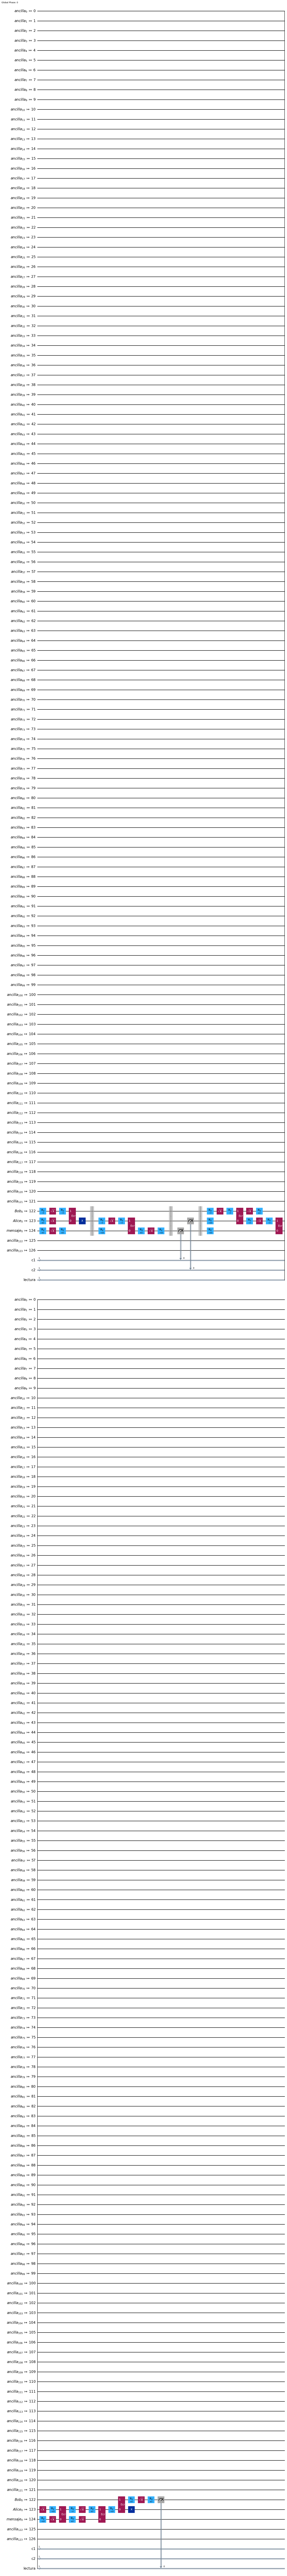

In [13]:
optimized_circuit.draw(output='mpl')

In [35]:
sampler = Sampler(mode=realbackend)
sampler.options.default_shots=1024
job = sampler.run([optimized_circuit])
print(f"Job ID is {job.job_id()}")

Job ID is cyzphf5x0acg00820f6g


In [36]:
real_result = job.result()

In [37]:
print(f"Total samples: {len(real_result[0].data.lectura.bitcount())}")
print(f"Number of ones: {real_result[0].data.lectura.bitcount().sum()}")

Total samples: 10000
Number of ones: 4813


# Eureka!

¡Hemos podido correr nuestro código en un ordenador cuántico de verdad!

Contando los resultados de total de muestras vs |1>s podemos ver que enc